In [1]:
#Reading, converting and removing irrelevant data

In [2]:
import pandas as pd

df = pd.read_csv('fil_data_movies_lessthan10k_removed.csv')
df = df.drop(columns=['id', 'title','release_date',  'adult','original_title', 'backdrop_path', 'homepage', 'imdb_id', 'overview', 'poster_path', 'tagline','spoken_languages' ])

In [3]:
df_encoded = pd.get_dummies(df['genres'].str.split(', ').explode()).groupby(level=0).sum()

df_encoded2 = pd.get_dummies(df['original_language'].str.split(', ').explode()).groupby(level=0).sum()
df_new = pd.DataFrame()
df_new['en'] = df_encoded2['en']
df_new['other'] = df_encoded2.drop('en', axis=1).sum(axis=1)

df_encoded3 = pd.get_dummies(df['production_companies'].str.split(', ').explode()).groupby(level=0).sum()
mask = (df_encoded3.sum() >= 180)
df_encoded3 = df_encoded3.loc[:, mask.values]

df_encoded4 = pd.get_dummies(df['production_countries'].str.split(', ').explode()).groupby(level=0).sum()
df_new2 = pd.DataFrame()
df_new2['United States of America'] = df_encoded4['United States of America']
df_new2['United Kingdom'] = df_encoded4['United Kingdom']
df_new2['other2'] = df_encoded4.drop(['United States of America', 'United Kingdom'], axis=1).sum(axis=1)

In [4]:
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns=['genres'])

df = pd.concat([df, df_new], axis=1)
df = df.drop(columns=['original_language'])

df = pd.concat([df, df_encoded3], axis=1)
df = df.drop(columns=['production_companies'])

df = pd.concat([df, df_new2], axis=1)
df = df.drop(columns=['production_countries'])

In [5]:
# Trying to use linear regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Define the features and the target
X = df.drop('vote_average', axis=1)
y = df['vote_average']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [7]:
# Import metrics
from sklearn import metrics

# Make predictions on the entire data set
y_pred_all = model.predict(X_test)

# Compare the predicted values with the actual values
df_scores_comp_all = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_all})

# Print the comparison dataframe
print(df_scores_comp_all)

      Actual  Predicted
641    6.616   6.318910
4933   6.179   6.071847
5932   5.762   6.093219
944    6.535   6.398673
7067   6.900   6.704737
...      ...        ...
4418   6.500   6.567628
1859   6.494   6.277890
863    5.588   6.112407
2355   6.237   6.001690
5319   6.811   6.416349

[1489 rows x 2 columns]


In [8]:
#Trying different models.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Create a list of models
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

# Define the hyperparameters for each model
hyperparameters = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {'max_depth': [None, 5, 10]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
}

for model in models:
    model_name = model.__class__.__name__
    
    # Initialize the grid search
    grid_search = GridSearchCV(model, hyperparameters[model_name])
    
    # Train the model with the grid search
    grid_search.fit(X_train, y_train)
    
    # Make predictions with the best found model
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    r2_percentage = r2 * 100
    print(f"Model: {model_name}, Best Hyperparameters: {grid_search.best_params_}, R-squared (%): {r2_percentage}")


Model: LinearRegression, Best Hyperparameters: {}, R-squared (%): 41.50224618316637
Model: DecisionTreeRegressor, Best Hyperparameters: {'max_depth': 5}, R-squared (%): 33.16991204856722
Model: RandomForestRegressor, Best Hyperparameters: {'max_depth': None, 'n_estimators': 300}, R-squared (%): 53.81156966700181


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_params_ = grid_search.best_params_
model = RandomForestRegressor(**best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R2 score: ", r2_score(y_test, y_pred))
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

R2 score:  0.535165157044539
Mean Absolute Error (MAE): 0.4187288582941572
Mean Squared Error (MSE): 0.3055194727570406
Root Mean Squared Error (RMSE): 0.5527381593096686


In [11]:
#Trying different parameters for the model

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_estimators = [10, 50, 100, 200, 500, 1000]
max_depths = [None, 5, 10, 15, 20, 30]

# Initialize lists to store the results
mae_results = []
mse_results = []
rmse_results = []
r2_results = []
parameters = []

# Loop over the hyperparameters
for n in n_estimators:
    for max_depth in max_depths:
        # Initialize the model with the current hyperparameters
        model = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate the metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Store the results
        mae_results.append(mae)
        mse_results.append(mse)
        rmse_results.append(rmse)
        r2_results.append(r2)
        parameters.append([n, max_depth])
        
        # Print the results
        if(r2>0.5):
            print(f'n_estimators: {n}, max_depth: {max_depth}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}')
        
smallest = 1
smallestN = 0
for i in range(len(mse_results)):
    if(mse_results[i]<smallest):
        smallest = mse_results[i]
        smallestN = i
print(f'n_estimators: {parameters[smallestN][0]}, max_depth: {parameters[smallestN][1]}, MAE: {mae_results[smallestN]}, MSE: {mae_results[smallestN]}, RMSE: {rmse_results[smallestN]}, R2: {r2_results[smallestN]}')

n_estimators: 50, max_depth: None, MAE: 0.4242510141034251, MSE: 0.3138451087645399, RMSE: 0.5602188043653479, R2: 0.522498057068467
n_estimators: 50, max_depth: 10, MAE: 0.4232993694336844, MSE: 0.31319386071927846, RMSE: 0.5596372581586027, R2: 0.5234889031841412
n_estimators: 50, max_depth: 15, MAE: 0.424048010028843, MSE: 0.31310750471327603, RMSE: 0.559560099286284, R2: 0.5236202901629357
n_estimators: 50, max_depth: 20, MAE: 0.42268652862330236, MSE: 0.31212308137588896, RMSE: 0.558679766392062, R2: 0.5251180482708122
n_estimators: 50, max_depth: 30, MAE: 0.4239807974706939, MSE: 0.3140356521963684, RMSE: 0.5603888401782894, R2: 0.5222081533663856
n_estimators: 100, max_depth: None, MAE: 0.4247050235057085, MSE: 0.31090278582968434, RMSE: 0.5575865724976565, R2: 0.5269746758810279
n_estimators: 100, max_depth: 10, MAE: 0.4226755978235802, MSE: 0.31083060765034787, RMSE: 0.5575218449983353, R2: 0.5270844919014404
n_estimators: 100, max_depth: 15, MAE: 0.4243032614271738, MSE: 0.31

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model = RandomForestRegressor(n_estimators=2000, max_depth=30, random_state=1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [14]:
#Different plots to make conclusions

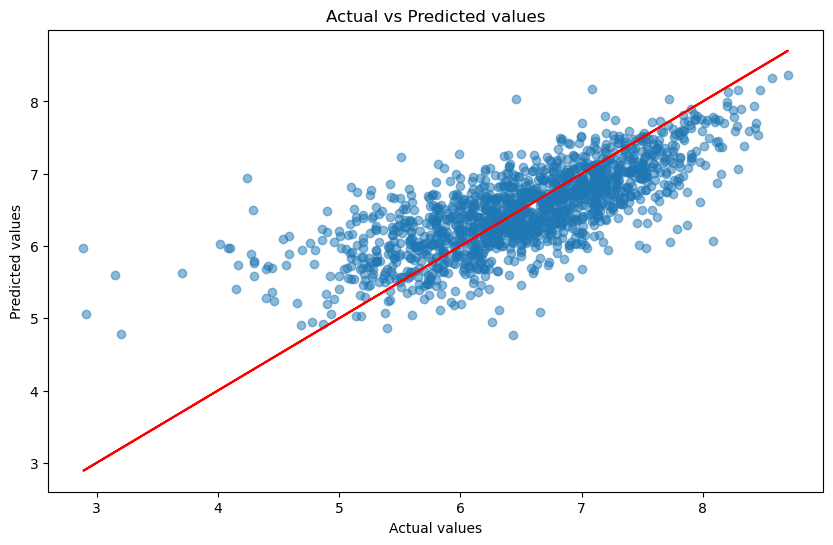

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')

plt.plot(y_test, y_test, 'r')

plt.show()


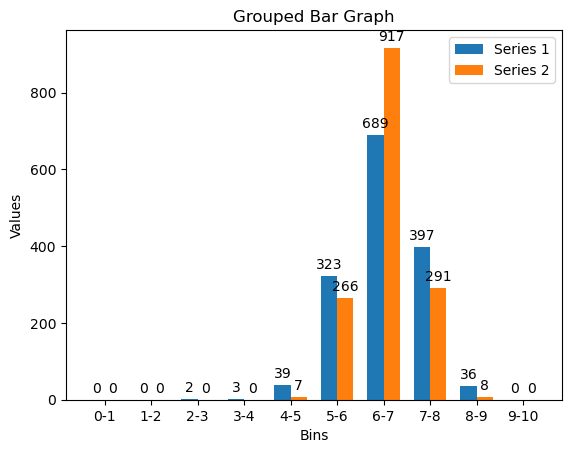

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 11, 1)  # Define the bins

# Create histogram for both series
series1_hist = np.histogram(y_test, bins=bins)
series2_hist = np.histogram(y_pred, bins=bins)

# Create an index for each group of bars
bar_width = 0.35
index = np.arange(len(bins)-1)

# Create the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, series1_hist[0], bar_width, label='Series 1')
bar2 = ax.bar(index + bar_width, series2_hist[0], bar_width, label='Series 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Bins')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Graph')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{i}-{i+1}' for i in bins[:-1]])
ax.legend()

# Function to add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call function to add value labels
add_labels(bar1)
add_labels(bar2)

plt.show()


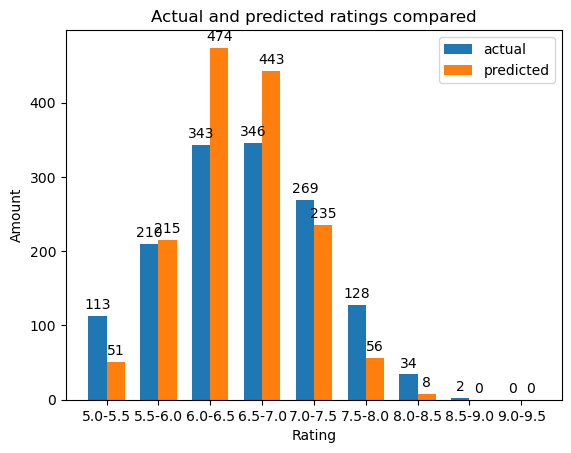

In [17]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(5, 10, 0.5)  # Define the bins

# Create histogram for both series
y_test_hist = np.histogram(y_test, bins=bins)
y_pred_hist = np.histogram(y_pred, bins=bins)

# Create an index for each group of bars
bar_width = 0.35
index = np.arange(len(bins)-1)

# Create the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, y_test_hist[0], bar_width, label='actual')
bar2 = ax.bar(index + bar_width, y_pred_hist[0], bar_width, label='predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Rating')
ax.set_ylabel('Amount')
ax.set_title('Actual and predicted ratings compared')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)])
ax.legend()

# Function to add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call function to add value labels
add_labels(bar1)
add_labels(bar2)

plt.show()


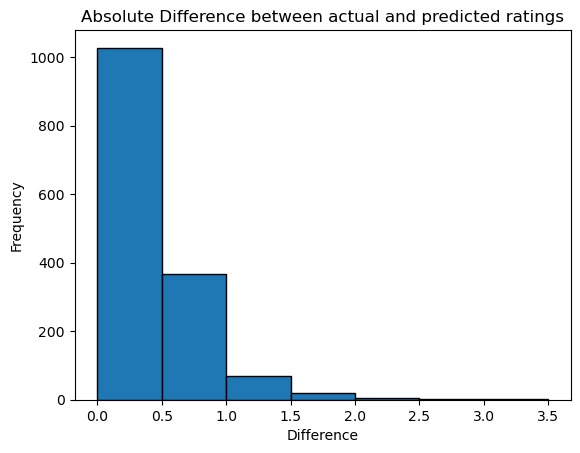

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the absolute difference
diff = np.abs(y_test - y_pred)

# Create bins of size 0.5
bins = np.arange(min(diff), max(diff) + 0.5, 0.5)

# Plot the histogram
plt.hist(diff, bins=bins, edgecolor='black')

plt.title('Absolute Difference between actual and predicted ratings')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.show()
